In [1]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

#### 95th percentile  treshold

In [2]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2023-11-1"):
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['date'])
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    
    cut_off_date = '2023-11-1'
    df = df[df['date'] <= pd.to_datetime(cut_off_date)]
    
    if df.empty:
        return None
    
    df['timestamp'] = df['date'].astype('datetime64[s]')
    df = df.sort_values(by=['timestamp'], ascending=True)
    
    if not df.empty:
        df['interval'] = df['timestamp'].diff().dt.total_seconds()
        
        mean_interval = df['interval'].mean()
        sd_interval = df['interval'].std()
        
        Z = df['interval'].max()
        percentile_95 = df['interval'].dropna().quantile(0.99)
        T = pd.to_datetime(current_time)
        T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
        time_since_last_commit_days = T_X_n / (60 * 60 * 24)
            
        classification = "unknown"
        if T_X_n > Z*2:
            # Reclassify as "alive" if within a certain SD from the mean
            if abs(T_X_n - mean_interval) < sd_interval:
                classification = "alive"
            else:
                classification = "dead"
        elif T_X_n < percentile_95:
            classification = "alive"
            
        mean_interval = mean_interval / (60 * 60 * 24)
        
        repo_name = os.path.basename(csv_file).split('.')[0]
        return {
            'Repo': repo_name,
            'Z': Z,
            'T_X_n': T_X_n,
            'Percentile_95': percentile_95,
            'MeanInterval(days)': mean_interval,
            'SDInterval': sd_interval,
            'Label': classification,
            'TimeSinceLastCommit(days)': time_since_last_commit_days
        }
    else:
        return None
    
folder_path = '/Users/ethan/Documents/Datascience/MQP/main_repo_df/Data/CommitData' 

#folder_path = '../../Data/CommitData'   
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

C:\Users\ethan\AppData\Local\Temp\ipykernel_28992\2796082730.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
C:\Users\ethan\AppData\Local\Temp\ipykernel_28992\2796082730.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


    classification = "unknown"
    if T_X_n > Z:
        classification = "dead"
        # If classified as dead but within 1 SD from the mean, reclassify as alive
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
    elif T_X_n < percentile_95:
        classification = "alive"
   

In [3]:
# Use pd.concat to create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

In [4]:

def split_repo_identifier(repo_identifier):
    if repo_identifier.startswith('C_'):
        repo_identifier = repo_identifier[2:]  # remove the 'C_' prefix
    parts = repo_identifier.split('_', 1)
    owner = parts[0]
    repo = parts[1] if len(parts) > 1 else ''
    return owner, repo

 
results_df[['Owner', 'Repo']] = results_df['Repo'].apply(lambda x: split_repo_identifier(x)).tolist()


results_df =results_df [['Repo', 'Owner','Z', 'T_X_n', 'Percentile_95', 'MeanInterval(days)',
       'SDInterval', 'Label', 'TimeSinceLastCommit(days)' ]]


In [5]:
results_df.to_csv('../data/df_95thp_labeled.csv', index=False)

In [6]:
results_df.head(1)

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,57748.88,0.074827,73483.954057,dead,797.4439


In [7]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1750.000000
mean      697.010614
std       916.319340
min         0.000359
25%        20.133247
50%       243.054242
75%      1125.422934
max      4959.900463
Name: TimeSinceLastCommit(days), dtype: float64

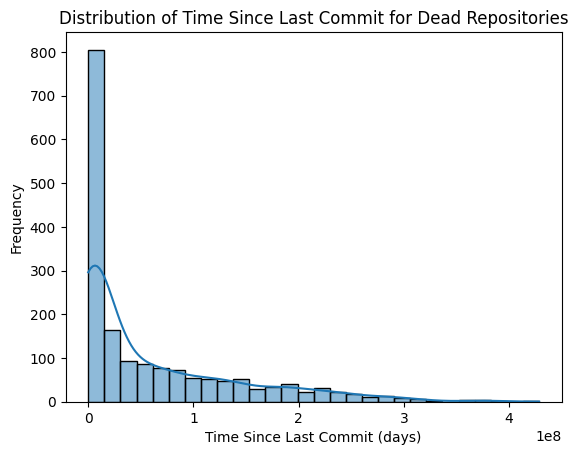

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(results_df['T_X_n'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


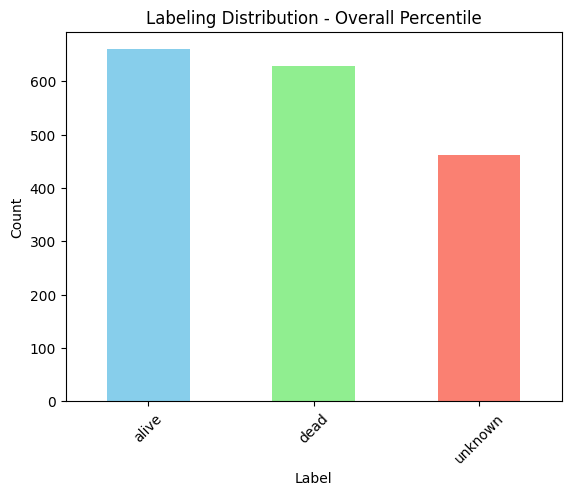

In [9]:
import matplotlib.pyplot as plt

classification_counts = results_df['Label'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Labeling Distribution - Overall Percentile')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

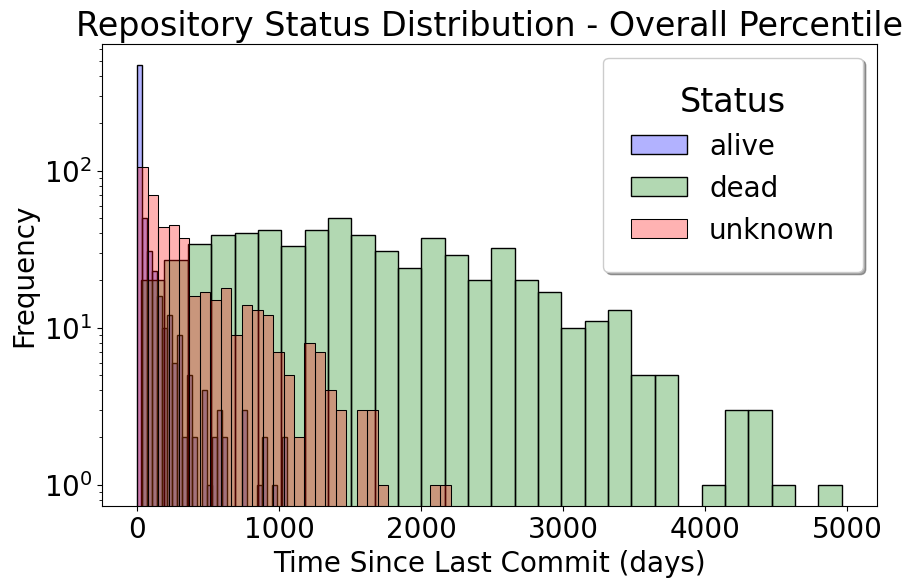

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


colors = {'alive': 'blue', 'dead': 'green', 'unknown': 'red'}

 
plt.rcParams.update({'font.size': 20, 'legend.title_fontsize': 'large'})
 
plt.figure(figsize=(10, 6))

# Create a histplot for each classification using Seaborn
for classification, color in colors.items():
    sns.histplot(data=results_df[results_df['Label'] == classification],
                 x='TimeSinceLastCommit(days)',
                 bins=30,
                 alpha=0.3,
                 label=classification,
                 color=color,
                 edgecolor='black')

plt.yscale('log')
plt.title('Repository Status Distribution - Overall Percentile')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
 
plt.legend(title='Status', frameon=True, shadow=True, borderpad=1)

plt.show()

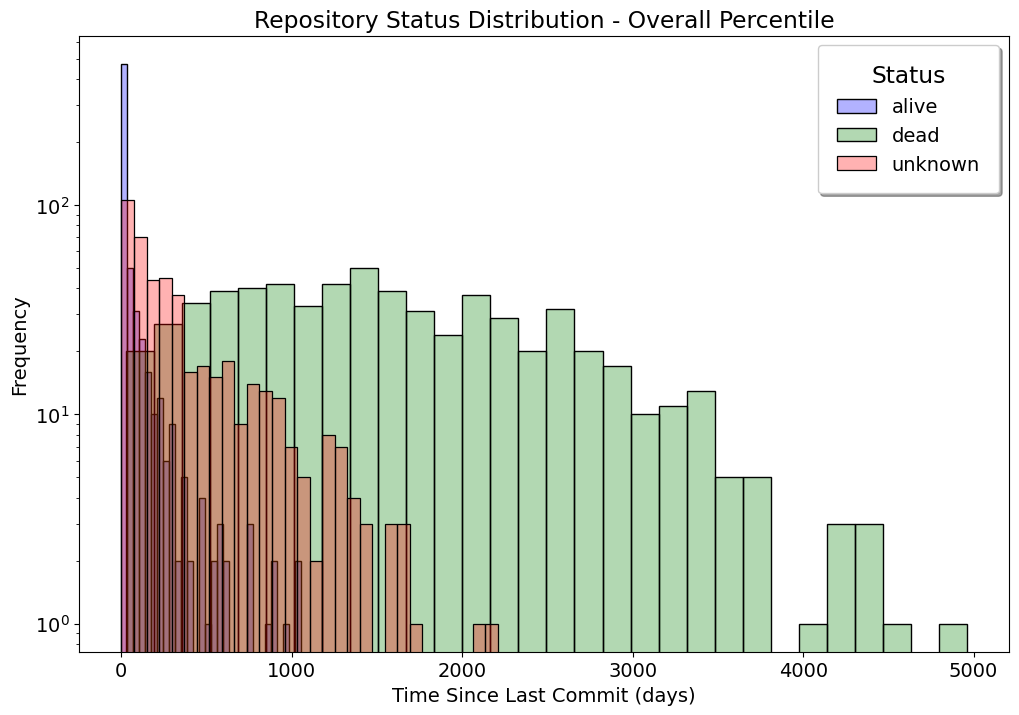

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

 
colors = {'alive': 'blue', 'dead': 'green', 'unknown': 'red'}

# Increase global font sizes using rcParams
plt.rcParams.update({'font.size': 14, 'legend.title_fontsize': 'large'})

 
plt.figure(figsize=(12, 8))

 
for classification, color in colors.items():
    sns.histplot(data=results_df[results_df['Label'] == classification],
                 x='TimeSinceLastCommit(days)',
                 bins=30,
                 alpha=0.3,
                 label=classification,
                 color=color,
                 edgecolor='black')

plt.yscale('log')
plt.title('Repository Status Distribution - Overall Percentile')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')

 

# Drawing the legend with increased size and with a frame
plt.legend(title='Status', frameon=True, shadow=True, borderpad=1)

plt.show()


#### Dead repos 

In [11]:
dead_repos_df = results_df[results_df['Label'] == 'dead']
dead_repos_df.head(10)

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,57748.88,0.074827,7.348395e+04,dead,797.443900
3,developer_quest,2d-inc,6848421.0,122169888.0,500962.82,0.628362,4.878035e+05,dead,1414.003333
7,iOS-Developer-and-Designer-Interview-Questions,9magnets,52066745.0,202473979.0,36757206.98,20.484703,8.236624e+06,dead,2343.448831
9,Leetcode-Questions,AbhishekChourasiya,356.0,123501401.0,356.00,0.004120,NaN,dead,1429.414363
11,node-restful-api-tutorial,academind,126883.0,186837657.0,125676.79,0.770515,8.529193e+04,dead,2162.472882
15,QuSimPy,adamisntdead,38543496.0,166963806.0,29657679.36,21.108072,6.988715e+06,dead,1932.451458
17,backbone-fundamentals,addyosmani,36341992.0,185787248.0,1794634.65,1.609746,1.089817e+06,dead,2150.315370
18,QQ,adiew-code,3740076.0,244159957.0,1570604.95,1.058159,3.754318e+05,dead,2825.925428
19,Daily-Interview-Question,Advanced-Frontend,13667537.0,93912781.0,3003633.00,2.627872,1.074078e+06,dead,1086.953484
20,qbit,advantageous,17727564.0,182494662.0,591294.90,0.723560,6.094417e+05,dead,2112.206736


In [12]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
309,Queen-Nithya-MD,DileepaTech,1106856.0,2465100.0,715572.22,0.448553,1.426844e+05,dead,28.531250
683,quill,joschan21,335908.0,2478866.0,334661.30,0.771978,1.167160e+05,dead,28.690579
863,LiteLoaderQQNT,LiteLoaderQQNT,847138.0,3270001.0,382349.23,0.343669,7.753578e+04,dead,37.847234
311,EX-3-SubQueries-Views-and-Joins,dineshgl,70637.0,3955839.0,67183.80,0.141022,2.864138e+04,dead,45.785174
313,QUEEN-HENTAI,dinuwah,1342483.0,4451791.0,487393.76,0.170437,1.013701e+05,dead,51.525359
...,...,...,...,...,...,...,...,...,...
1137,phpQuery,punkave,364.0,376822234.0,364.00,0.004213,NaN,dead,4361.368449
875,NewQuickAction3D,lorensiuswlt,7033736.0,380068774.0,6786744.76,18.357984,3.067312e+06,dead,4398.944144
570,quora,huacnlee,4059969.0,380569967.0,795069.36,0.371762,2.176633e+05,dead,4404.744988
1112,jQuery-MD5,placemarker,7546712.0,390821102.0,7231883.04,19.857190,2.504764e+06,dead,4523.392384


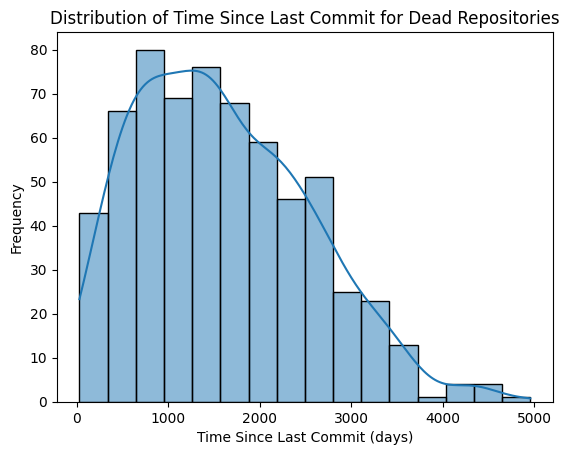

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


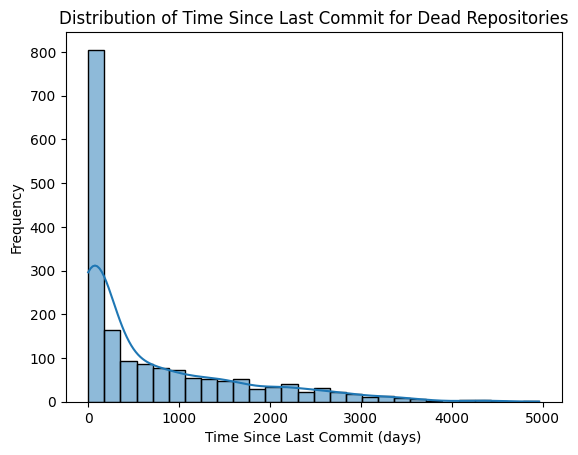

In [14]:
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [15]:
alive_repos_df = results_df[results_df['Label'] == 'alive']
alive_repos_df.head(10)

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,5.262055e+07,30.238753,1.018087e+07,alive,53.686644
6,Quantumult-X,89996462,4064823.0,297323.0,4.300909e+05,0.500326,2.449188e+05,alive,3.441238
12,road-runner-quickstart,acmerobotics,17714735.0,873624.0,1.625137e+07,12.270346,2.756169e+06,alive,10.111389
27,lottie-android,airbnb,6212738.0,157247.0,2.152107e+06,1.713934,4.341001e+05,alive,1.819988
28,lottie-ios,airbnb,15959705.0,960380.0,2.358349e+06,2.289223,6.761220e+05,alive,11.115509
29,qemu_blog,airbus-seclab,24165616.0,13280964.0,2.367059e+07,51.195907,8.593245e+06,alive,153.714861
31,video-quality,aizvorski,118991936.0,78483197.0,1.069994e+08,154.036456,3.033368e+07,alive,908.370336
32,ace,ajaxorg,9323013.0,135904.0,6.055322e+05,0.572947,1.819120e+05,alive,1.572963
33,awesome-java,akullpp,9444133.0,303519.0,2.946462e+06,2.058184,6.446983e+05,alive,3.512951
34,Alamofire,Alamofire,8360313.0,447125.0,2.568626e+06,2.094928,5.561558e+05,alive,5.175058


In [16]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
664,vue2-MiniQQ,jiangqizheng,106179566.0,91184083.0,9.372389e+07,97.276102,2.827443e+07,alive,1055.371331
196,QrCodeScan,chentao0707,193643383.0,90865192.0,1.768451e+08,241.074126,6.076016e+07,alive,1051.680463
342,html5-qrcode,dwa012,163789712.0,84626766.0,1.010558e+08,65.078948,2.482597e+07,alive,979.476458
31,video-quality,aizvorski,118991936.0,78483197.0,1.069994e+08,154.036456,3.033368e+07,alive,908.370336
1514,Aristo-jQuery-UI-Theme,taitems,254797562.0,76855995.0,1.502307e+08,90.497521,3.781132e+07,alive,889.536979
...,...,...,...,...,...,...,...,...,...
1251,QuestPDF,QuestPDF,3350155.0,2095.0,1.507475e+06,1.416817,3.022375e+05,alive,0.024248
1310,react-querybuilder,react-querybuilder,16481185.0,2023.0,1.879896e+06,1.174377,6.502465e+05,alive,0.023414
189,certbot,certbot,11234277.0,1904.0,4.455703e+05,0.385285,2.181577e+05,alive,0.022037
1258,quickemu,quickemu-project,17278602.0,807.0,1.918949e+06,1.173626,7.126034e+05,alive,0.009340


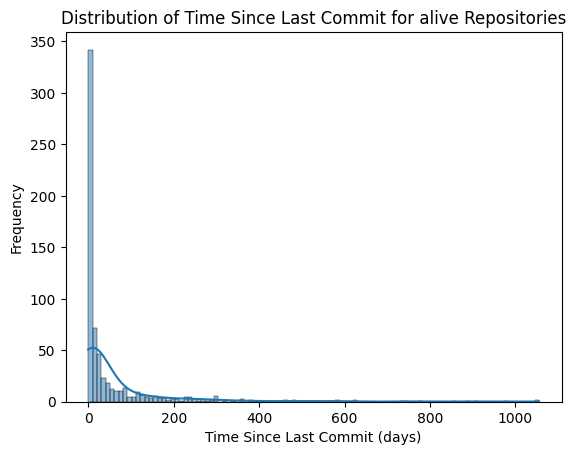

In [17]:
sns.histplot(alive_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for alive Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [18]:
dead_repos_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,57748.88,0.074827,7.348395e+04,dead,797.443900
3,developer_quest,2d-inc,6848421.0,122169888.0,500962.82,0.628362,4.878035e+05,dead,1414.003333
7,iOS-Developer-and-Designer-Interview-Questions,9magnets,52066745.0,202473979.0,36757206.98,20.484703,8.236624e+06,dead,2343.448831
9,Leetcode-Questions,AbhishekChourasiya,356.0,123501401.0,356.00,0.004120,NaN,dead,1429.414363
11,node-restful-api-tutorial,academind,126883.0,186837657.0,125676.79,0.770515,8.529193e+04,dead,2162.472882
...,...,...,...,...,...,...,...,...,...
1735,QQRobot,zeruniverse,35938314.0,202511030.0,7617106.78,7.630874,3.731387e+06,dead,2343.877662
1739,QASystemOnMedicalGraph,zhihao-chen,5260996.0,140123163.0,4919143.32,8.984473,1.491984e+06,dead,1621.795868
1741,AiQiangGUO,zhuxuedefeng,8192130.0,77047176.0,7539664.08,12.130486,2.297861e+06,dead,891.749722
1742,awesome-php,ziadoz,9841058.0,40185453.0,3449589.05,2.447083,6.796128e+05,dead,465.109410


#### Unknown

In [19]:
unknown = results_df[results_df['Label'] == 'unknown']

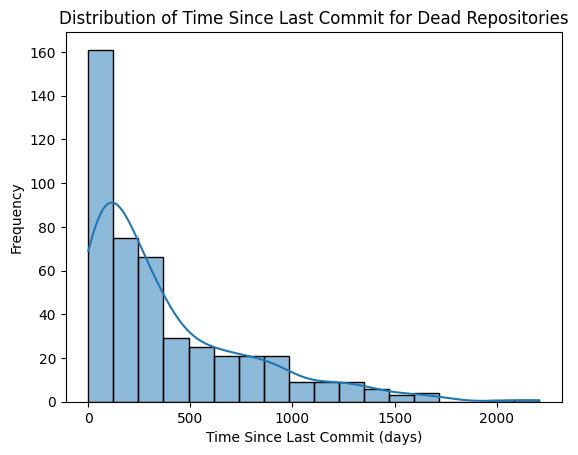

In [20]:
sns.histplot(unknown['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Repo Validation Status  

  github api to verify; if 'verify' or 'Error' manualy look up and check status 

In [21]:
import pandas as pd
import requests
from datetime import datetime, timedelta

df = results_df  

def check_repo_status_and_date(owner, repo_name, token, alive_threshold=30, verify_threshold=90):
    headers = {
        'Authorization': f'token {token}',
        'Accept': 'application/vnd.github.v3+json'
    }
    url = f'https://api.github.com/repos/{owner}/{repo_name}/commits'
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        commits = response.json()
        if commits:
            latest_commit_date_str = commits[0]['commit']['committer']['date']
            latest_commit_date = datetime.strptime(latest_commit_date_str, '%Y-%m-%dT%H:%M:%SZ')
            days_since_last_commit = (datetime.utcnow() - latest_commit_date).days
            status = 'True' if days_since_last_commit < alive_threshold else ('verify' if days_since_last_commit <= verify_threshold else 'False')
            return status, latest_commit_date_str
        else:
            return 'False', None  
    else:
        print(f"Error fetching repo {repo_name}: {response.status_code}")
        return 'Error', None  

token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'

df['Status'] = 'Error'
df['Last_Commit_Date'] = None


for index, row in df.iterrows():
    status, last_commit_date = check_repo_status_and_date(row['Owner'], row['Repo'], token)
    df.at[index, 'Status'] = status
    df.at[index, 'Last_Commit_Date'] = last_commit_date

df.head()


Error fetching repo fullPage: 404
Error fetching repo Chart: 404
Error fetching repo validator: 404
Error fetching repo qikqiak: 404
Error fetching repo Quartz: 404
Error fetching repo jQuery: 404
Error fetching repo Parsley: 404
Error fetching repo reveal: 404
Error fetching repo hammer: 404
Error fetching repo jQuery: 404
Error fetching repo jQuery: 404
Error fetching repo fabric: 404
Error fetching repo qart: 404
Error fetching repo queues: 404
Error fetching repo backbone: 404
Error fetching repo graph: 404
Error fetching repo jQuery: 404
Error fetching repo mithril: 404
Error fetching repo Newbe: 404
Error fetching repo nw: 404
Error fetching repo qqwry: 404
Error fetching repo paper: 404
Error fetching repo pixi: 404
Error fetching repo qbzzt: 404
Error fetching repo qiubaiying: 404
Error fetching repo qpython3: 404
Error fetching repo QuantEcon: 404
Error fetching repo QuantEcon: 404
Error fetching repo quarkusio: 404
Error fetching repo org: 404
Error fetching repo quran: 404
E

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,57748.88,0.074827,7.348395e+04,dead,797.443900,False,2021-08-25T13:20:47Z
1,linux-insides,0xAX,9252379.0,5226272.0,2072525.42,1.654147,5.514041e+05,unknown,60.489259,False,2023-09-01T12:15:28Z
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,28776555.90,41.994261,9.370872e+06,unknown,381.272384,verify,2024-01-03T12:12:34Z
3,developer_quest,2d-inc,6848421.0,122169888.0,500962.82,0.628362,4.878035e+05,dead,1414.003333,False,2019-12-17T23:55:12Z
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,52620549.82,30.238753,1.018087e+07,alive,53.686644,False,2023-09-08T07:31:14Z


#### Manual Validation 
Selecting a random row from dead adn alive and finding the github and verfyiing if it is alive or dead  

In [24]:
alive_repos_df = df[df['Label'] == 'alive']
random_row_alive = alive_repos_df.sample(n=1)
random_row_alive

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
685,jQuery-SlotMachine,josex2r,75541528.0,31298340.0,59895333.12,19.715262,9.090192e+06,alive,362.249306,False,2022-11-03T18:01:00Z


In [25]:
dead_repos_df = df[df['Label'] == 'dead']
random_row_dead = dead_repos_df.sample(n=1)
random_row_dead

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
763,anko,Kotlin,24112009.0,123260420.0,2601108.38,1.82007,870645.227962,dead,1426.625231,False,2019-12-05T08:59:40Z


In [150]:
alive_repos_df.to_csv('../data/alive_repos_df.csv', index=False)

In [149]:
dead_repos_df.to_csv('../data/dead_repos_df.csv', index=False)

In [27]:
 
TP = 43  # True Positives
TN = 48  # True Negatives
FP = 7  # False Positives
FN = 2  # False Negatives

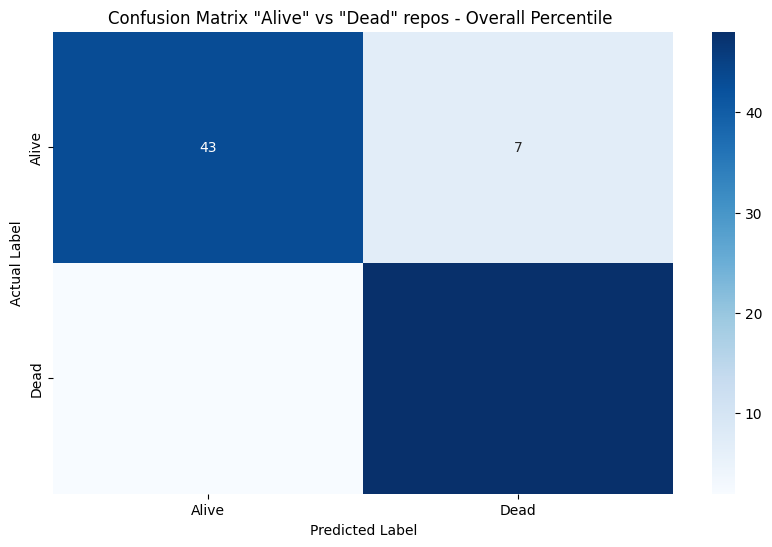

In [1]:
 
import matplotlib.pyplot as plt
import seaborn as sns

 
TP = 43  # True Positives
TN = 48  # True Negatives
FP = 7   # False Positives
FN = 2   # False Negatives

confusion_mtx = [[TP, FP], [FN, TN]]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix "Alive" vs "Dead" repos - Overall Percentile ')

plt.show()


In [29]:
results_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,57748.88,0.074827,7.348395e+04,dead,797.443900,False,2021-08-25T13:20:47Z
1,linux-insides,0xAX,9252379.0,5226272.0,2072525.42,1.654147,5.514041e+05,unknown,60.489259,False,2023-09-01T12:15:28Z
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,28776555.90,41.994261,9.370872e+06,unknown,381.272384,verify,2024-01-03T12:12:34Z
3,developer_quest,2d-inc,6848421.0,122169888.0,500962.82,0.628362,4.878035e+05,dead,1414.003333,False,2019-12-17T23:55:12Z
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,52620549.82,30.238753,1.018087e+07,alive,53.686644,False,2023-09-08T07:31:14Z
...,...,...,...,...,...,...,...,...,...,...,...
1745,qrcode,zpao,31729003.0,243718.0,17436501.08,14.949914,3.856684e+06,alive,2.820810,Error,None
1746,rule_for_quantumultX,zqzess,606525.0,167234.0,605081.98,1.167113,1.754097e+05,alive,1.935579,True,2024-02-29T07:07:17Z
1747,quick_psd2ugui,zs9024,58344447.0,52406855.0,28574030.14,27.239227,7.661345e+06,unknown,606.560822,False,2022-03-04T10:32:25Z
1748,zxing,zxing,5990254.0,118115.0,1893611.80,1.559213,3.716090e+05,alive,1.367072,True,2024-02-26T13:38:04Z


## Came back alive repos 

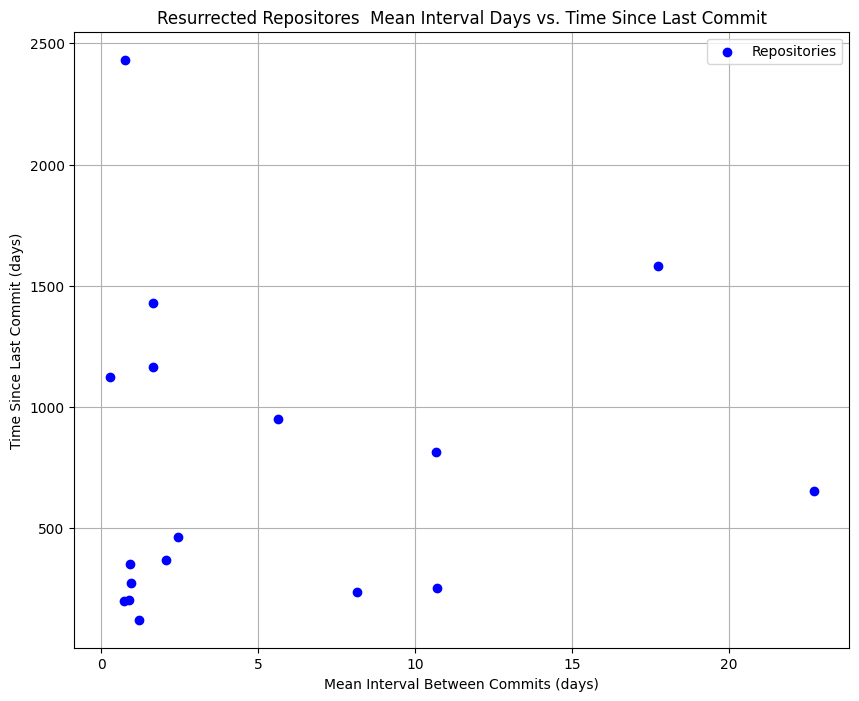

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

 
data = {
    "Repo": ["qrpicture", "NLP_Quickbook", "pythondict-quant", "awesome-php", "Qure", "ZenQ", "udemy-REACT-QUERY", "amazeui", "ProjectQ", "express", "pm2", "linux-sysadmin-interview-questions", "test-your-sysadmin-skills", "ai_quant_trade", "qor-example", "isucon9-qualify", "qa_page_object"],
    "Owner": ["xyzzy", "NirantK", "Ckend", "ziadoz", "Koolson", "alphadose", "bonnie", "amazeui", "ProjectQ-Framework", "expressjs", "Unitech", "chassing", "trimstray", "charliedream1", "qor", "isucon", "mate-academy"],
    "T_X_n": [16764640, 18822873, 12713681, 9841058, 7419046, 5417638, 7102737, 16680884, 9514383, 8469663, 6676338, 15520051, 8462821, 3674536, 38368283, 24905634, 80923],
    "Percentile_95": [10734429.97, 13501436.52, 12033932.51, 3449589.05, 3603234.65, 1694593.64, 6783115.12, 967167.29, 7848510.4, 1591583.53, 925820.4, 12471435.1, 3072621.4, 1149250.9, 1372123.67, 76870.14, 80915.97],
    "MeanInterval(days)": [5.625385706, 10.66697096, 22.70529059, 2.447083097, 2.0468869, 0.900245858, 10.68245448, 0.737818124, 8.137665576, 0.871708718, 0.723270268, 17.7367969, 1.629694758, 1.20804966, 1.660343746, 0.262992687, 0.932540509],
    "SDInterval": [2649111.812, 2595151.147, 3553927.841, 679612.789, 679950.813, 421508.661, 1687588.378, 509199.605, 1605359.807, 376942.989, 269740.851, 3082331.411, 657663.163, 276875.314, 1228717.377, 611776.891, 497.096],
    "TimeSinceLastCommit(days)": [949.214734, 812.752153, 654.498113, 465.10941, 370.740706, 351.774363, 255.217211, 2432.468692, 236.33059, 203.477928, 201.674491, 1580.439699, 1428.696863, 122.423727, 1166.842604, 1125.436609, 272.423588]
}

df = pd.DataFrame(data)

 
plt.figure(figsize=(10, 8))
plt.scatter(df["MeanInterval(days)"], df["TimeSinceLastCommit(days)"], c='blue', label='Repositories')
plt.title('Resurrected Repositores  Mean Interval Days vs. Time Since Last Commit')
plt.xlabel('Mean Interval Between Commits (days)')
plt.ylabel('Time Since Last Commit (days)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#folder_path = '/Users/ethan/Documents/Datascience/MQP/main_repo_df/Data/CommitData'    

In [46]:
import os
import pandas as pd

folder_path = '/Users/ethan/Documents/Datascience/MQP/main_repo_df/Data/CommitData'    
 
repo_list = [
"C_xyzzy_qrpicture",
"C_NirantK_NLP_Quickbook",
"C_Ckend_pythondict-quant",
"C_ziadoz_awesome-php",
"C_Koolson_Qure",
"C_alphadose_ZenQ",
"C_bonnie_udemy-REACT-QUERY",
"C_amazeui_amazeui",
"C_ProjectQ-Framework_ProjectQ",
"C_expressjs_express",
"C_Unitech_pm2",
"C_chassing_linux-sysadmin-interview-questions",
"C_trimstray_test-your-sysadmin-skills",
"C_charliedream1_ai_quant_trade",
"C_qor_qor-example",
"C_isucon_isucon9-qualify",
"C_mate-academy_qa_page_object",

]


commit_dates = {repo: [] for repo in repo_list}

# Iterate over the files in the specified folder
for file_name in os.listdir(folder_path):
    # Extract the repo name from the file name
    repo_name = os.path.splitext(file_name)[0]
    
    # Check if the repo name is in the list of repos we're interested in
    if repo_name in repo_list:
        # Read the commit history from the CSV file
        csv_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(csv_path)
        df = df.dropna(subset=['date'])
        

        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        
 
        commit_dates[repo_name].extend(df['date'].tolist())



In [54]:
df = df[[ 'owner', 'repo', 'author', 'date', 'totalAdditions',
       'totalDeletions']]

In [59]:
df

,index,owner,repo,author,date,totalAdditions,totalDeletions,net_change,year,y_value
0,1566,ziadoz,awesome-php,invalid-email-address,2012-01-25 18:12:11+00:00,24,0,24,2012,0
1,1565,ziadoz,awesome-php,ziadoz,2012-02-23 21:08:26+00:00,9,2,7,2012,0
2,1564,ziadoz,awesome-php,ziadoz,2012-02-23 21:30:17+00:00,1,0,1,2012,0
3,1563,ziadoz,awesome-php,ziadoz,2012-02-23 21:30:45+00:00,1,1,0,2012,0
4,1562,ziadoz,awesome-php,ziadoz,2012-02-27 23:10:53+00:00,4,2,2,2012,0
...,...,...,...,...,...,...,...,...,...,...
1562,4,ziadoz,awesome-php,ziadoz,2022-06-02 12:14:16+00:00,6,7,-1,2022,0
1563,3,ziadoz,awesome-php,ziadoz,2022-06-02 12:48:13+00:00,1,1,0,2022,0
1564,2,ziadoz,awesome-php,Kalyse,2022-07-01 21:44:38+00:00,1,0,1,2022,0
1565,1,ziadoz,awesome-php,timgates42,2022-07-03 22:03:17+00:00,3,3,0,2022,0


C:\Users\ethan\AppData\Local\Temp\ipykernel_15292\360035747.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_value'] = df['repo'].map(repo_y_values)


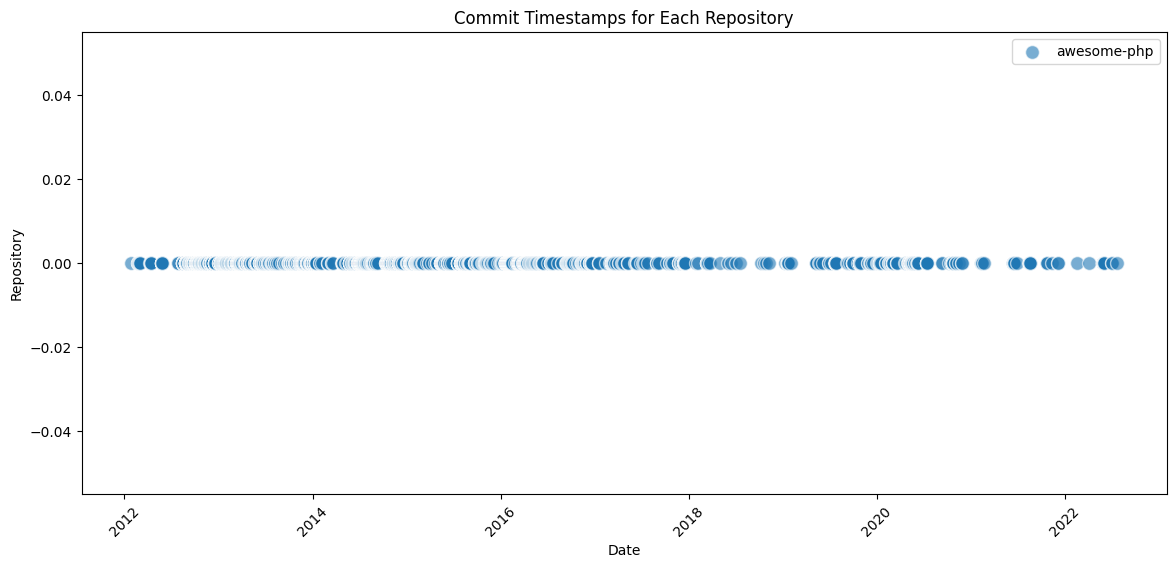

In [58]:
repo_y_values = {repo: i for i, repo in enumerate(df['repo'].unique())}

# Now we'll add a new column to the dataframe for the y-values based on the repo
df['y_value'] = df['repo'].map(repo_y_values)

 
plt.figure(figsize=(14, 6))

for repo, group in df.groupby('repo'):
    plt.scatter(group['date'], group['y_value'], label=repo, alpha=0.6, edgecolors='w', s=100)
plt.title('Commit Timestamps for Each Repository')
plt.xlabel('Date')
plt.ylabel('Repository')
 
plt.xticks(rotation=45)
 
plt.legend()

 
plt.show()


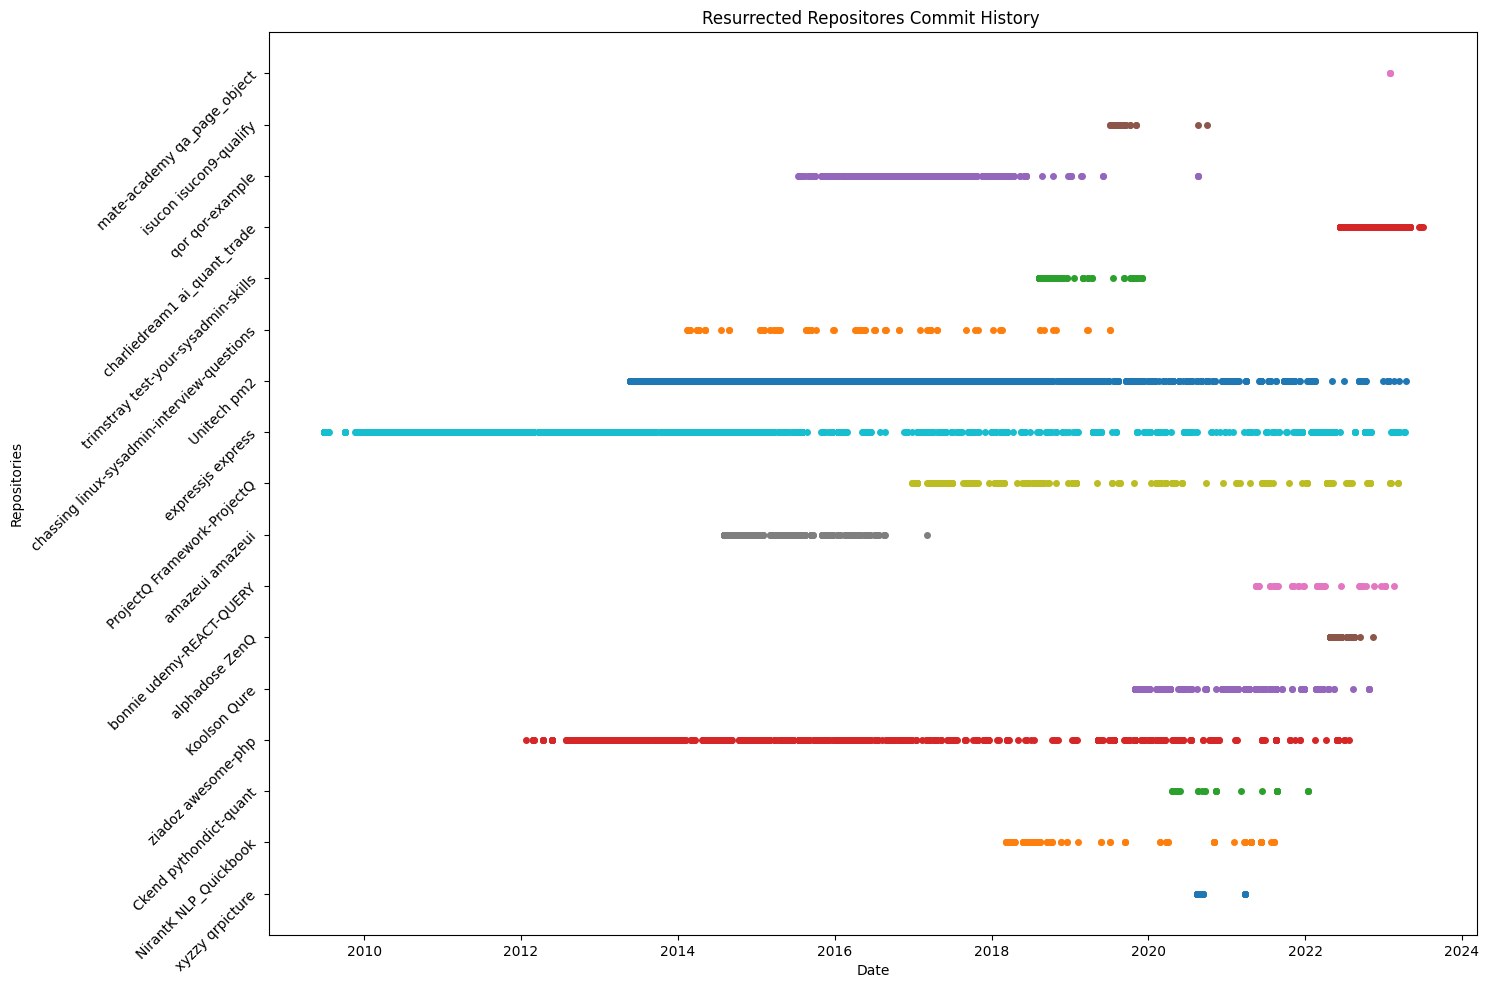

In [66]:
repo_names = ["xyzzy qrpicture",
"NirantK NLP_Quickbook",
"Ckend pythondict-quant",
"ziadoz awesome-php",
"Koolson Qure",
"alphadose ZenQ",
"bonnie udemy-REACT-QUERY",
"amazeui amazeui",
"ProjectQ Framework-ProjectQ",
"expressjs express",
"Unitech pm2",
"chassing linux-sysadmin-interview-questions",
"trimstray test-your-sysadmin-skills",
"charliedream1 ai_quant_trade",
"qor qor-example",
"isucon isucon9-qualify",
"mate-academy qa_page_object"]

y_values = range(len(repo_names))

plt.figure(figsize=(15, 10))
 
for repo, dates in commit_dates.items():
    if dates:   
        plt.plot(dates, [repo] * len(dates), marker='o', linestyle='None', markersize=4, label=repo)
        
 
plt.yticks(y_values, repo_names, rotation=45)
plt.title('Resurrected Repositores Commit History')
plt.xlabel('Date')
plt.ylabel('Repositories')
plt.yticks(rotation=45)  
plt.tight_layout()   
plt.show()


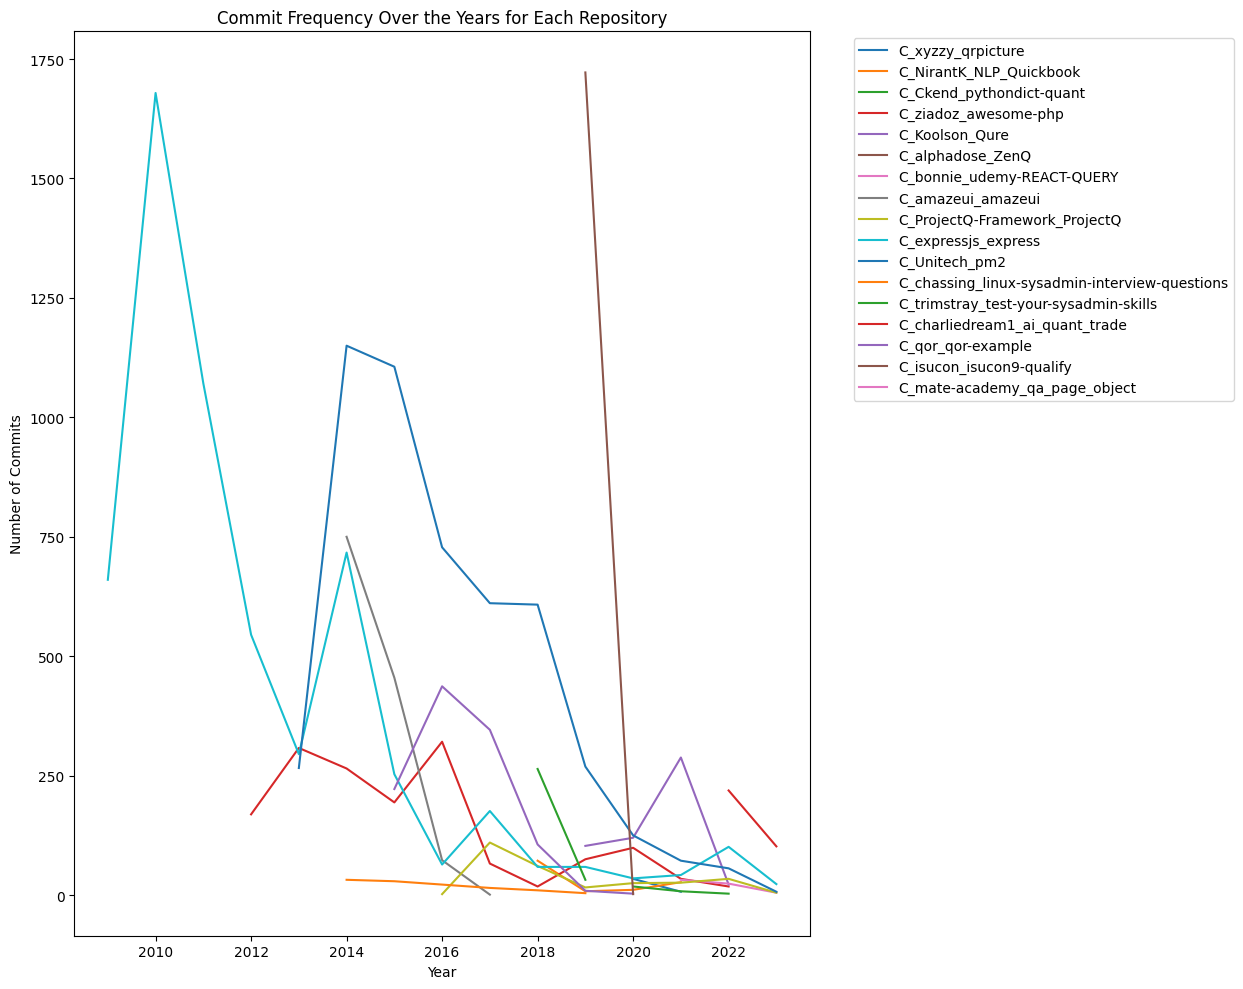

In [69]:
repo_names = ["xyzzy qrpicture",
"NirantK NLP_Quickbook",
"Ckend pythondict-quant",
"ziadoz awesome-php",
"Koolson Qure",
"alphadose ZenQ",
"bonnie udemy-REACT-QUERY",
"amazeui amazeui",
"ProjectQ Framework-ProjectQ",
"expressjs express",
"Unitech pm2",
"chassing linux-sysadmin-interview-questions",
"trimstray test-your-sysadmin-skills",
"charliedream1 ai_quant_trade",
"qor qor-example",
"isucon isucon9-qualify",
"mate-academy qa_page_object"]

y_values = range(len(repo_names))



commit_counts_per_year = {repo: {} for repo in repo_list}

for repo, dates in commit_dates.items():
    if dates:
        for date in dates:
            year = date.year   
            commit_counts_per_year[repo].setdefault(year, 0)
            commit_counts_per_year[repo][year] += 1
 
plt.figure(figsize=(15, 10))

 
for repo, counts in commit_counts_per_year.items():
 
    years = sorted(counts.keys())
    commits = [counts[year] for year in years]
    if years and commits:
        plt.plot(years, commits, label=repo)


# Set the labels and title
plt.title('Commit Frequency Over the Years for Each Repository')
plt.xlabel('Year')
plt.ylabel('Number of Commits')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')   
plt.tight_layout(rect=[0, 0, 0.85, 1])   

 
plt.show()


### Whole df validation (dno't use )

In [ ]:
df = df[df['Classification'] != "unknown"]

In [ ]:
TP = 0  # True Positive
TN = 0  # True Negative
FP = 0  # False Positive
FN = 0  # False Negative
mismatch_or_verify = []  # Rows for verification or with mismatches
 
for index, row in df.iterrows():
   
    status = row['Status'] == 'True'  
    if row['Classification'] == 'alive' and status:
        TP += 1
    elif row['Classification'] == 'dead' and not status:
        TN += 1
    elif row['Status'] == 'verify':
        mismatch_or_verify.append(row)
    elif row['Classification'] == 'dead' and row['Status'] == 'Error':
        TN += 1  
        mismatch_or_verify.append(row)
    elif row['Classification'] == 'alive' and row['Status'] == 'Error':
        FN += 1   
        mismatch_or_verify.append(row)
    else:
        if row['Classification'] == 'alive' and not status:
            FN += 1   
        elif row['Classification'] == 'dead' and status:
            FP += 1  # Classified as dead but is actually alive (True)
        else:
            mismatch_or_verify.append(row)
 
mismatch_verify_df = pd.DataFrame(mismatch_or_verify)

TP, TN, FP, FN

(255, 781, 26, 91)

In [ ]:
255+ 781+ 26+ 91 +67

1220

In [ ]:
TP = TP +67 
TN = TN -10
FP = FP 
FN = FN +10

In [ ]:
pd.set_option('display.max_rows', None)

mismatch_verify_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 35 to 1737
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Repo                       67 non-null     object 
 1   Owner                      67 non-null     object 
 2   Z                          67 non-null     float64
 3   T_X_n                      67 non-null     float64
 4   Percentile_95              67 non-null     float64
 5   MeanInterval(days)         67 non-null     float64
 6   SDInterval                 67 non-null     float64
 7   Classification             67 non-null     object 
 8   TimeSinceLastCommit(days)  67 non-null     float64
 9   Is_Alive                   67 non-null     bool   
 10  Status                     67 non-null     object 
 11  Last_Commit_Date           67 non-null     object 
dtypes: bool(1), float64(6), object(5)
memory usage: 6.3+ KB


In [ ]:
not_alive_or_true_df = df[(df['Classification'] == 'alive')]
not_alive_or_true_df.to_csv('../data/not_alive_or_true_df.csv', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Repo                       1751 non-null   object 
 1   Owner                      1751 non-null   object 
 2   Z                          1751 non-null   float64
 3   T_X_n                      1751 non-null   float64
 4   Percentile_95              1751 non-null   float64
 5   MeanInterval(days)         1751 non-null   float64
 6   SDInterval                 1732 non-null   float64
 7   Classification             1751 non-null   object 
 8   TimeSinceLastCommit(days)  1751 non-null   float64
 9   Is_Alive                   1704 non-null   object 
 10  Status                     1751 non-null   object 
 11  Last_Commit_Date           0 non-null      object 
dtypes: float64(6), object(6)
memory usage: 164.3+ KB


#### Validation Confusion Matrix 

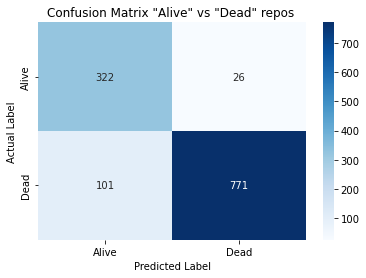

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


confusion_mtx = [[TP, FP],
                 [FN, TN]]

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix "Alive" vs "Dead" repos ')
plt.show()



In [ ]:
results_df.columns

Index(['Repo', 'Owner', 'Z', 'T_X_n', 'Percentile_95', 'MeanInterval(days)',
       'SDInterval', 'Classification', 'TimeSinceLastCommit(days)'],
      dtype='object')

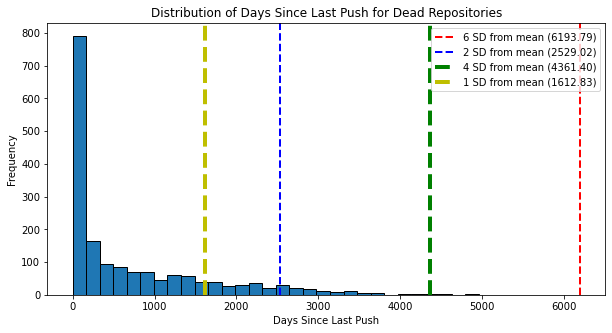

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


mean_value = results_df['TimeSinceLastCommit(days)'].mean()
std_dev = results_df['TimeSinceLastCommit(days)'].std()

# Calculate the position of the line at 6 standard deviations from the mean
line_position = mean_value + 6*std_dev


plt.figure(figsize=(10, 5))
plt.hist(results_df['TimeSinceLastCommit(days)'], bins=30,  edgecolor='black')
plt.title('Distribution of Days Since Last Push for Dead Repositories')
plt.xlabel('Days Since Last Push')
plt.ylabel('Frequency')

line_position = mean_value + 6*std_dev
plt.axvline(line_position, color='r', linestyle='dashed', linewidth=2, label=f'6 SD from mean ({line_position:.2f})')

line_position = mean_value + 2*std_dev
plt.axvline(line_position, color='b', linestyle='dashed', linewidth=2, label=f'2 SD from mean ({line_position:.2f})')

line_position = mean_value + 4*std_dev
plt.axvline(line_position, color='g', linestyle='dashed', linewidth=4, label=f'4 SD from mean ({line_position:.2f})')

line_position = mean_value + 1*std_dev
plt.axvline(line_position, color='y', linestyle='dashed', linewidth=4, label=f'1 SD from mean ({line_position:.2f})')


plt.legend()
plt.show()



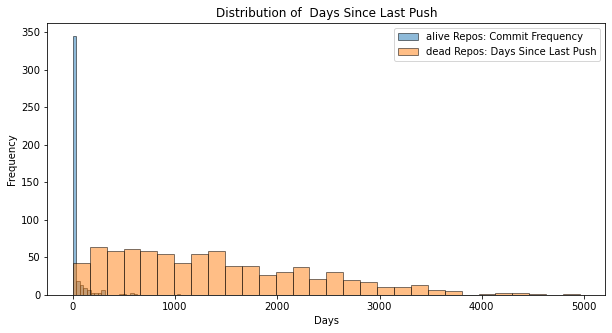

In [ ]:

plt.figure(figsize=(10, 5))

# Plotting 'commitFrequency' for dead repositories
plt.hist(alive_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='alive Repos: Commit Frequency', edgecolor='black')

# Plotting 'daysSinceLastPush' for alive repositories
plt.hist(dead_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='dead Repos: Days Since Last Push', edgecolor='black')

# Adding title, labels, and legend
plt.title('Distribution of  Days Since Last Push')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()



#### merge datasets

In [ ]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
